In [1]:
import random

from nltk.corpus import stopwords
import pandas as pd
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import LdaModel
from gensim.models import CoherenceModel

import numpy as np

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
# load all metadata

stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gorka\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gorka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gorka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\gorka\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Load the Data

In [2]:
#Cargamos los datos
labelY = 'issue_area'
labelX = 'facts'
data = pd.read_csv('justice.csv')
data = data[data[labelY].notna()]
X = data[labelX].tolist()
Y = data[labelY].tolist()
print(len(X), len(Y), len(data))

3161 3161 3161


Data Pre-Proccesing Funtions

In [3]:
#Pasa las etiquetas escritas a valores numéricos
def getLabels(Y):
    names = []
    newY =  []
    for i in Y:
        if i not in names:
            names.append(str(i))
        newY.append(names.index(str(i)))
    return newY, names

In [4]:
#Pasamos la etiquetas de FirstPartyWinner a valores numéricos
y_labels, y_names = getLabels(Y)

In [5]:
#Elimina signos de puntuación y todo a minúsculas
def sent_to_words(sentences):
    for sentence in sentences:
        yield (gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

#data_words = list(sent_to_words(X))

In [6]:
#Eliminamos las stop words
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

#data_words_nostops = remove_stopwords(data_words)

In [7]:
lem = WordNetLemmatizer()
ps = PorterStemmer()

In [8]:
#Lematizamos
def lemmatization(texts):
    texts_out = []
    for text in texts:
        lemText = []
        for sent in text:
            stemmed = ps.stem(sent)
            lemText.append(lem.lemmatize(stemmed))
        texts_out.append(lemText)
    return texts_out

#data_lemmatized = lemmatization(data_words_nostops)

Topic Modeling Representation Functions

In [9]:
#Crea un modelo con n numero de Topics en relación a los datos administrados
#Utilizamos 202 porque hemos visto en el proyecto que son los que mejor Accuracy nos proporcionan
def get_topicModeling(data, n_topics):
    #Topic modeling
    id2word = corpora.Dictionary(data)
    texts = data
    corpus = [id2word.doc2bow(text) for text in texts]
    lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=n_topics, random_state=100, passes=10, eval_every=None)
    topics = lda_model.print_topics(-1)
    return lda_model,corpus,topics

#model, corpus, topics = get_topicModeling(data_lemmatized,202)

In [10]:
def get_vectorized(model, corpus):
    n_topics = model.num_topics
    vectorized = []
    #Recorrer los documentos
    for i in model[corpus]:
        #Inicializar index como lista de ceros, de longitud 'n_topics'
        index = [0]*n_topics
        #Recorrer cada palabra de cada documento
        for n in i:
            #En index[8] guardamos la informacion del tópico 8
            index[n[0]] = n[1]
        vectorized.append(index)
    vectorized = pd.DataFrame(vectorized)
    #Filas documentos (facts)
    #Columnas topics
    return vectorized


#vectorized = get_vectorized(model,corpus)

In [11]:
from sklearn.decomposition import  PCA

#Redimensiona los datos introducidos a las dimensiones pedidas
def get_PCA(data, nPCA):
    print("Before:", data.shape)
    #pca = PCA(n_components='mle', svd_solver='full')
    pca = PCA(n_components=nPCA)
    pca.fit(data)
    data_PCA= pca.transform(data)
    print("After:", data_PCA.shape)
    return data_PCA, pca


TF-IDF Representation Functions

In [12]:
def computeTF(wordDict, bagOfWords):
    tfDict = {}
    bagOfWordsCount = len(bagOfWords)
    for word, count in wordDict.items():
        tfDict[word] = count / float(bagOfWordsCount)
    return tfDict

def computeIDF(documents):
    import math
    N = len(documents)

    idfDict = dict.fromkeys(documents[0].keys(), 0)
    for document in documents:
        for word, val in document.items():
            if val > 0:
                idfDict[word] += 1

    for word, val in idfDict.items():
        idfDict[word] = math.log(N / float(val)) # type: ignore 
    return idfDict

def computeTFIDF(tfBagOfWords, idfs):
    tfidf = {}
    for word, val in tfBagOfWords.items():
        tfidf[word] = val * idfs[word]
    return list(tfidf.values())

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
def get_tf_idf(X):
    data_words = list(sent_to_words(X))
    data_words_nostops = remove_stopwords(data_words)
    data_lemmatized = lemmatization(data_words_nostops)
    bag_of_words = []
    for data in data_lemmatized:
        for word in data:
            if not (word in bag_of_words):
                bag_of_words.append(word)

    dictionary = []
    data_tf = []
    for data in data_lemmatized:
        num_of_words = dict.fromkeys(bag_of_words, 0)
        for word in data:
            num_of_words[word] += 1
        dictionary.append(num_of_words)
        data_tf.append(computeTF(num_of_words,bag_of_words))

    data_idf = computeIDF(dictionary)

    data_tf_idf = []
    for data in data_tf:
        data_tf_idf.append(computeTFIDF(data, data_idf))
    return data_tf_idf

Traint Test Separations Functions

In [14]:
from sklearn.model_selection import train_test_split
def train_test(data, labels, perc):
    return train_test_split(data,labels,test_size=perc, random_state=1)
#Probamos con 30% de test y 70% de train
#X_train, X_test, Y_train, Y_test = train_test(vectorized, Y, 0.3)

In [15]:
def get_train_test(nTopics, perc, X, Y, nPCA=None):
    data_words = list(sent_to_words(X))
    data_words_nostops = remove_stopwords(data_words)
    data_lemmatized = lemmatization(data_words_nostops)
    model,corpus,topics = get_topicModeling(data_lemmatized, nTopics)
    vectorized = get_vectorized(model,corpus)
    if nPCA:
        data_PCA, pca = get_PCA(vectorized,nPCA)
        return train_test(data_PCA, Y, perc)
    return train_test(vectorized, Y, perc)

Classifier Scores Function

In [16]:
from sklearn.metrics import precision_recall_fscore_support, cohen_kappa_score, f1_score, accuracy_score, \
    balanced_accuracy_score, classification_report


def get_scores(Y_test, Y_pred , visualize=False):
    f_score = accuracy_score(Y_test, Y_pred) #Accuracy and F-Score are the same in classification
    balanced_accuracy = balanced_accuracy_score(Y_test, Y_pred)
    precision_macro, recall_macro, f_score_macro, support_macro = precision_recall_fscore_support(Y_test, Y_pred, average="macro", zero_division=0)
    precision_weighted, recall_weighted, f_score_weighted, support_weighted = precision_recall_fscore_support(Y_test, Y_pred, average="weighted", zero_division=0)
    kappa = cohen_kappa_score(Y_test, Y_pred)
    kappa_linear = cohen_kappa_score(Y_test, Y_pred, weights='linear')
    kappa_quadratic = cohen_kappa_score(Y_test, Y_pred, weights='quadratic')
    if visualize:
        print(f"f_score {f_score}") #Accuracy and F-Score are the same in classification
        print(f"Balanced Accuracy {balanced_accuracy}")
        print(f"Kappa Score {kappa}")
        print(f"Kappa Linear Score {kappa_linear}")
        print(f"Kappa Quadratic Score {kappa_quadratic}")
        print(classification_report(Y_test, Y_pred, zero_division=0))
        cm = get_cm(Y_test, Y_pred)

    return f_score, balanced_accuracy, precision_macro, recall_macro, f_score_macro, precision_weighted, recall_weighted, f_score_weighted, kappa, kappa_linear, kappa_quadratic

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Devuelve la matriz de confusion
def get_cm(Y_labels, predictions, visual = True):
    # El atributo generado por K-means es int, hay que pasarlos a string
    to_string = lambda x : str(x)
    # Obtener matriz de confusión Class to clustering eval
    cm = confusion_matrix(Y_labels, predictions)

    if visual:
        # Mapa de calor a partir de la matriz de confusion
        ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(Y_labels), yticklabels=np.unique(Y_labels)) # type: ignore 

    return cm

Functions for Plots

In [18]:
def get_topic_scores(df, x_index, y_index, z_index, z):
    nTopics = []
    nTopicsScore = []
    for d in df.values:
        if d[z_index] == z or z_index == x_index or z_index == y_index:
            d[x_index] = str(d[x_index]) if type(d[x_index]) is not int else d[x_index]
            if d[x_index] in nTopics:
                nTopicsScore[nTopics.index(d[x_index])].append(d[y_index])
            else:
                nTopics.append(d[x_index])
                nTopicsScore.append([d[y_index]])
    return  nTopics, nTopicsScore

In [19]:
def get_plot_scores(csv, x_label, y_label, func, z_label=None):
    df_scores = pd.read_csv(csv)

    x_index = list(df_scores.columns.values).index(x_label)
    y_index = list(df_scores.columns.values).index(y_label)

    if z_label is None:
        z_label = 'Score'
        z_values = ['Score']
        z_index = x_index
    elif type(z_label) is str:
        z_index = list(df_scores.columns.values).index(z_label)
        z_values = df_scores[z_label].unique()
    else:
        z_values = z_label
        z_index = y_index
        y_label = '%'

    for z in z_values:
        if y_index == z_index:
            y_index = list(df_scores.columns.values).index(z)
            z_index = y_index
        nTopics, nTopicsScore = get_topic_scores(df_scores, x_index, y_index, z_index, z)
        for s in range(len(nTopicsScore)):
            nTopicsScore[s] = func(nTopicsScore[s])
        df = pd.DataFrame({
              'x_axis': nTopics,
              'y_axis': nTopicsScore
          })
        df.sort_values('x_axis', ignore_index=True, inplace=True)
        plt.plot('x_axis', 'y_axis', data=df, linestyle='-', marker='o', label=z)




    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if type(z_label) is str:
        plt.title(f"{x_label} and {y_label} Comparison with {z_label}")
    else:
        plt.title(f"{x_label} and {y_label} Comparison")
    plt.legend()
    plt.show()

Decision Tree Classifier

f_score 0.4815595363540569
Balanced Accuracy 0.2872735799379979
Kappa Score 0.3738367765685664
Kappa Linear Score 0.34258852205706325
Kappa Quadratic Score 0.33631833332991523
                      precision    recall  f1-score   support

           Attorneys       0.00      0.00      0.00         8
        Civil Rights       0.44      0.44      0.44       147
  Criminal Procedure       0.71      0.74      0.72       271
         Due Process       0.16      0.12      0.13        43
   Economic Activity       0.49      0.52      0.51       169
    Federal Taxation       0.57      0.50      0.53        16
          Federalism       0.16      0.13      0.14        38
     First Amendment       0.42      0.44      0.43       105
Interstate Relations       0.00      0.00      0.00         1
      Judicial Power       0.24      0.24      0.24       105
       Miscellaneous       0.20      0.20      0.20         5
             Privacy       0.53      0.45      0.49        20
      Private Act

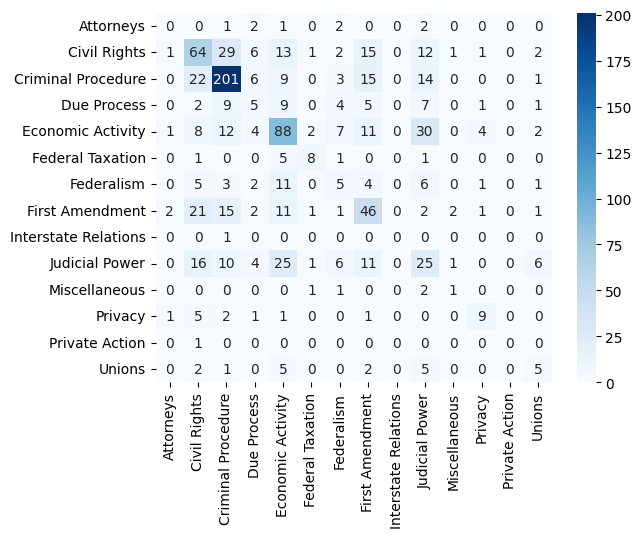

In [20]:
#DECISION TREE
from sklearn.tree import DecisionTreeClassifier

def decision_tree(X_train, Y_train, md=None):
    clf = DecisionTreeClassifier(max_depth=md)
    clf = clf.fit(X_train,Y_train)
    return clf
#Probamos con máxima repetición 3

X_train, X_test, Y_train, Y_test = get_train_test(200, 0.3, X, Y)
clf = decision_tree(X_train, Y_train)
Y_pred = clf.predict(X_test)
scores = get_scores(Y_test, Y_pred, True)

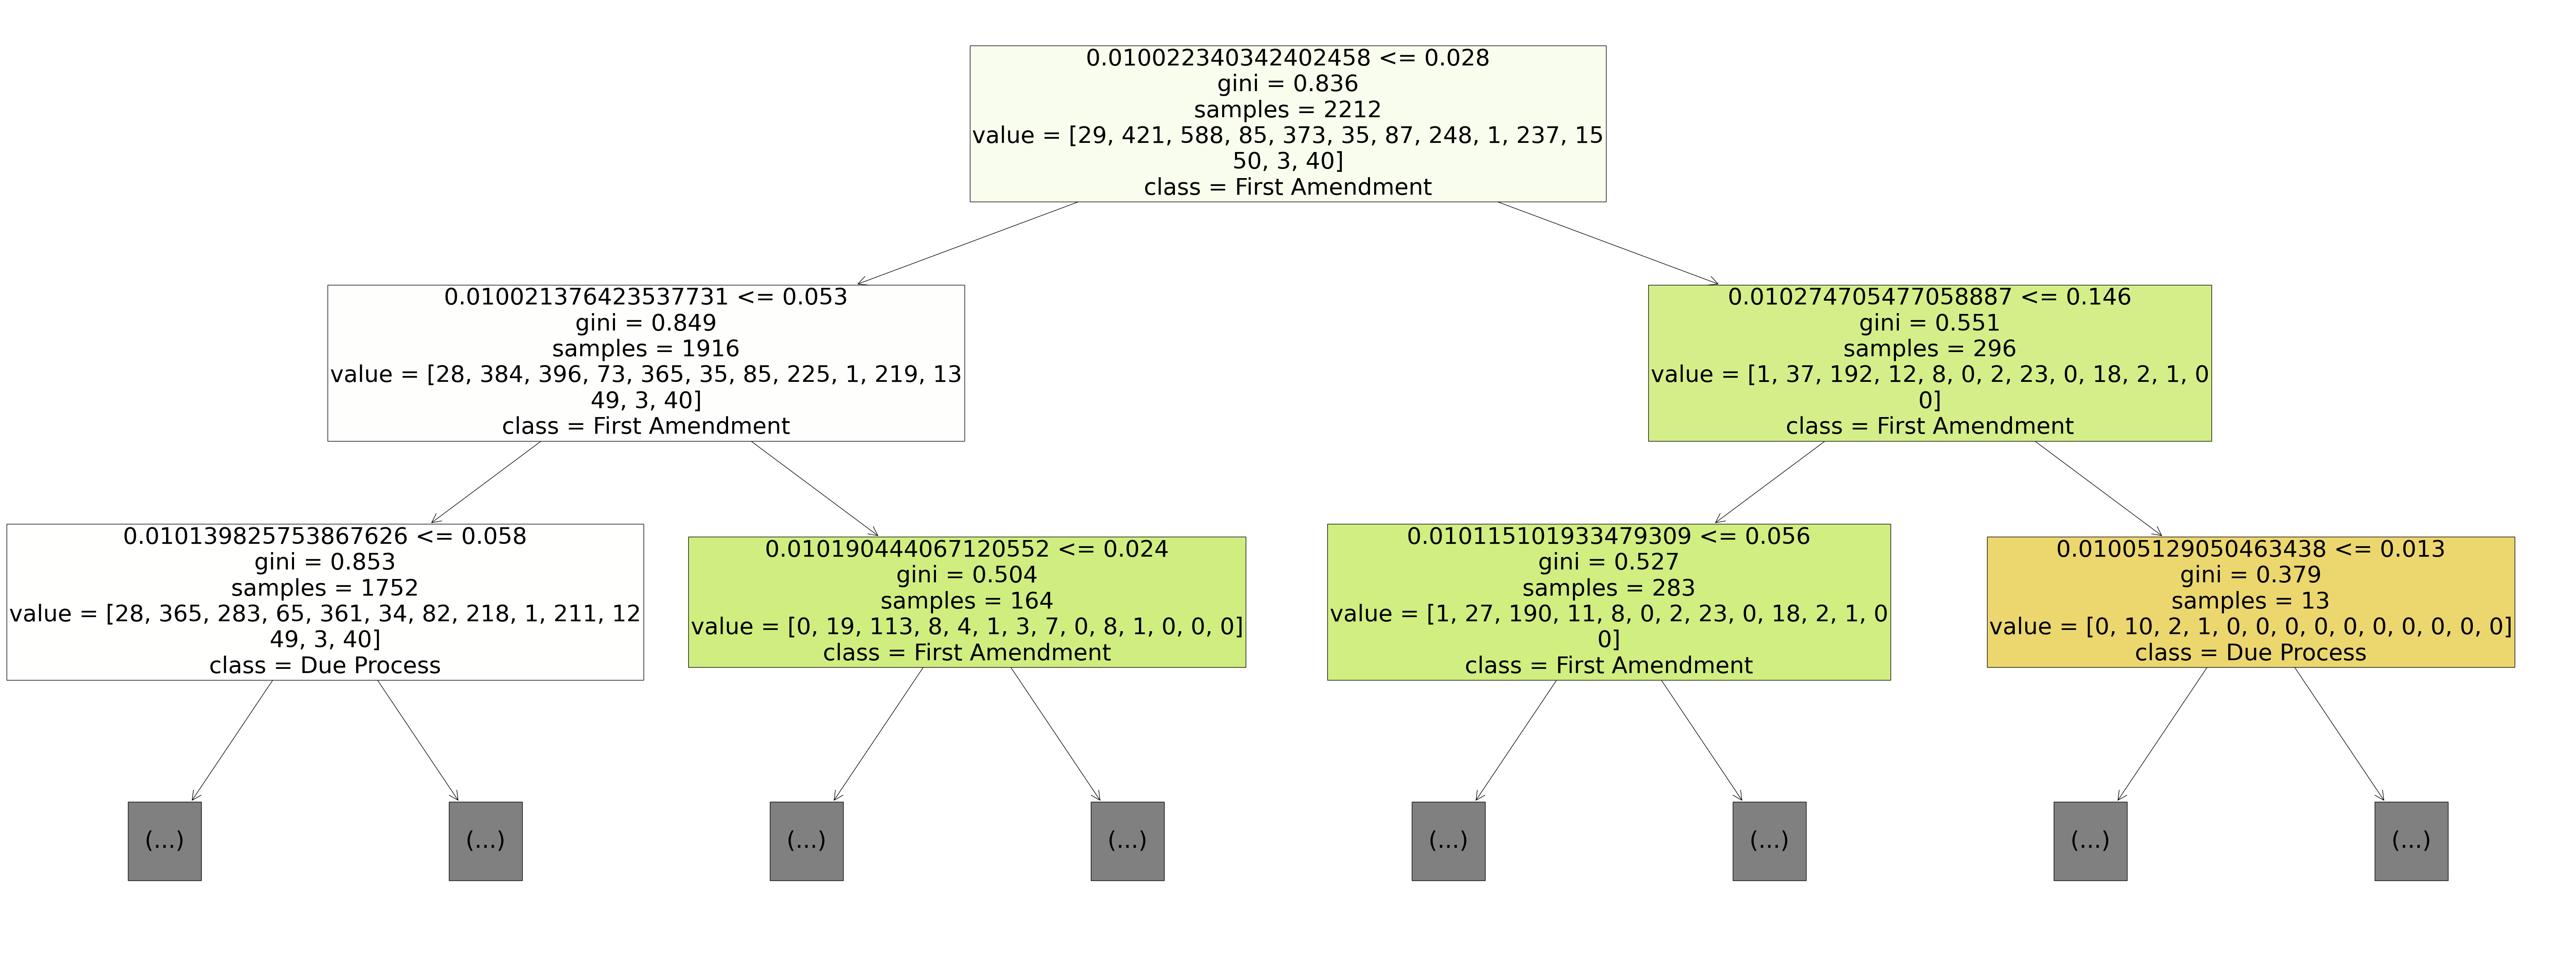

In [21]:
from matplotlib import pyplot as plt
from sklearn import tree

fig = plt.figure(figsize=(80,30))
tree = tree.plot_tree(clf,filled=True, class_names=y_names, feature_names=np.unique(X_train), max_depth=2, fontsize=40)


Best SGDClassifier search

In [22]:
from sklearn.linear_model import SGDClassifier


def get_all(X,Y, range_topics, range_loss, range_penalty, range_alpha, range_l1_ratio, range_fit_intercept, range_tol, range_shuffle, range_learning_rate, range_eta0, range_class_weight, range_average, max_iter):
    scores = []
    cont = 0
    data_words = list(sent_to_words(X))
    data_words_nostops = remove_stopwords(data_words)
    data_lemmatized = lemmatization(data_words_nostops)
    for t in range_topics:
        model,corpus,topics = get_topicModeling(data_lemmatized, t)
        vectorized = get_vectorized(model,corpus)
        X_train, X_test, Y_train, Y_test = train_test(vectorized, Y, 0.25)
        for loss in range_loss:
            for penalty in range_penalty:
                for alpha in range_alpha:
                    for l1_ratio in [x for x in range_l1_ratio if penalty == 'elasticnet' or x==0.15]:
                        for fit_intercept in range_fit_intercept:
                            for tol in range_tol:
                                for shuffle in range_shuffle:
                                    for learning_rate in range_learning_rate:
                                        for eta0 in [x for x in range_eta0 if learning_rate in ['constant', 'invscaling', 'adaptive'] or x==0.5]:
                                            for class_weight in range_class_weight:
                                                for average in range_average:
                                                    clf = SGDClassifier(
                                                    loss=loss,
                                                    penalty=penalty,
                                                    alpha=alpha,
                                                    l1_ratio=l1_ratio,
                                                    fit_intercept=fit_intercept,
                                                    max_iter=max_iter,
                                                    tol=tol,
                                                    shuffle=shuffle,
                                                    learning_rate=learning_rate,
                                                    eta0=eta0,
                                                    class_weight=class_weight,
                                                    average=average).fit(X_train, Y_train)

                                                    Y_pred = clf.predict(X_test)
                                                    score=[t, loss, penalty, alpha, l1_ratio, fit_intercept, tol, shuffle, learning_rate, eta0, class_weight, average, max_iter]
                                                    score += get_scores(Y_test,Y_pred)
                                                    scores.append(score.copy())
                                                    cont+=1
                                                    if cont % 100 == 0:
                                                        print(cont, loss, penalty, alpha, l1_ratio, fit_intercept, tol, shuffle, learning_rate, eta0, class_weight, average)
                                                    if cont % 1000 == 0:
                                                        df_scores = pd.DataFrame(scores)
                                                        df_scores = df_scores.set_axis(['topics', 'loss', 'penalty', 'alpha', 'l1_ratio', 'fit_intercept', 'tol', 'shuffle', 'learning_rate', 'eta0', 'class_weight', 'average', 'max_iter', 'f_score', 'balanced_accuracy', 'precision_macro', 'recall_macro', 'f_score_macro', 'precision_weighted', 'recall_weighted', 'f_score_weighted', 'kappa', 'kappa_linear', 'kappa_quadratic'], axis="columns")
                                                        df_scores.to_csv(f"scores_issue_area{cont}.csv", encoding="utf-8", sep=',',index=False, header=True)

    df_scores = pd.DataFrame(scores)
    df_scores = df_scores.set_axis(['topics', 'loss', 'penalty', 'alpha', 'l1_ratio', 'fit_intercept', 'tol', 'shuffle', 'learning_rate', 'eta0', 'class_weight', 'average', 'max_iter', 'f_score', 'balanced_accuracy', 'precision_macro', 'recall_macro', 'f_score_macro', 'precision_weighted', 'recall_weighted', 'f_score_weighted', 'kappa', 'kappa_linear', 'kappa_quadratic'], axis="columns")
    df_scores.to_csv("scores_issue_area1.csv", encoding="utf-8", sep=',',index=False, header=True)
    return scores

range_topics = [200]
range_loss = ['hinge', 'log_loss', 'log', 'modified_huber', 'squared_hinge', 'perceptron']
range_penalty = ['l1', 'l2', 'elasticnet']
range_alpha = [0.001, 0.0001, 0.00001] #Deafault = 0.0001
range_l1_ratio = [0.5, 0.15, 0.1] #Default = 0.15 #Only used in penalty = 'elasticnet'
range_fit_intercept = [True, False]
range_tol = [0.1, 0.05, 0.005] #Default =~ 0.05
range_shuffle = [True, False] #Default = 0.1 #Only use in loss = 'huber' 'epsilon_insensitive' or 'squared_epsilon_insensitive'
range_learning_rate = ['constant', 'optimal', 'invscaling', 'adaptive']
range_eta0 = [1, 0.5, 0.01] #Default = 0.5 #Only used in learning_rate = 'constant' 'invscaling' or 'adaptive'
range_class_weight = [None, 'balanced']
range_average = [True, 10, False]
max_iter = 1000

#get_all(X,Y , range_topics, range_loss, range_penalty, range_alpha, range_l1_ratio, range_fit_intercept, range_tol, range_shuffle, range_learning_rate, range_eta0, range_class_weight, range_average, max_iter)

In [23]:
df = pd.read_csv('scores_issue_area1.csv')
max_f_score = df.values[df['f_score'].argmax()]
max_balanced_accuracy = df.values[df['balanced_accuracy'].argmax()]
max_f_score_weighted = df.values[df['f_score_weighted'].argmax()]
max_kappa = df.values[df['kappa'].argmax()]
print(max_f_score)
print(max_balanced_accuracy)
print(max_f_score_weighted)
print(max_kappa)

[200 'modified_huber' 'l1' 0.001 0.15 False 0.05 True 'constant' 0.5 nan
 'False' 1000 0.6359039190897599 0.3638061756815592 0.4466793524096949
 0.3638061756815592 0.3675121473350479 0.6256710456540756
 0.6359039190897599 0.6124824563329206 0.5525543574332685
 0.5044014164183441 0.4900080229476291]
[200 'hinge' 'elasticnet' 1e-05 0.5 False 0.1 True 'constant' 1.0
 'balanced' 'False' 1000 0.5006321112515802 0.5292237562686538
 0.329719368382554 0.5292237562686538 0.3445791744268214
 0.5798943116273961 0.5006321112515802 0.522850733897997
 0.4203526360509512 0.3964286287688723 0.3956775105395324]
[200 'modified_huber' 'l1' 0.001 0.15 False 0.05 True 'constant' 0.5 nan
 'False' 1000 0.6359039190897599 0.3638061756815592 0.4466793524096949
 0.3638061756815592 0.3675121473350479 0.6256710456540756
 0.6359039190897599 0.6124824563329206 0.5525543574332685
 0.5044014164183441 0.4900080229476291]
[200 'modified_huber' 'l1' 0.001 0.15 False 0.05 True 'constant' 0.5 nan
 'False' 1000 0.635903919

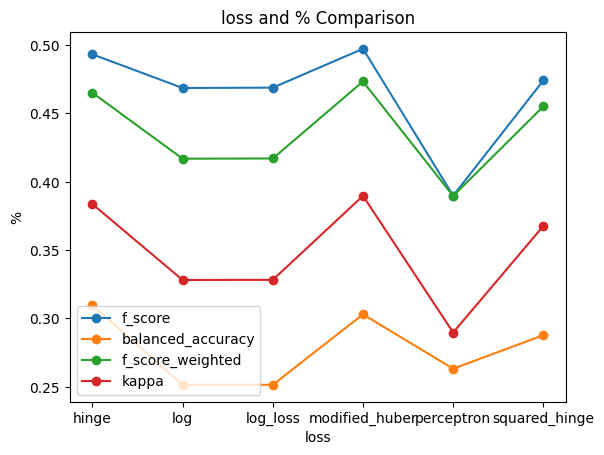

In [24]:
get_plot_scores("scores_issue_area1.csv","loss","f_score", np.mean, ['f_score', 'balanced_accuracy', 'f_score_weighted', 'kappa'])

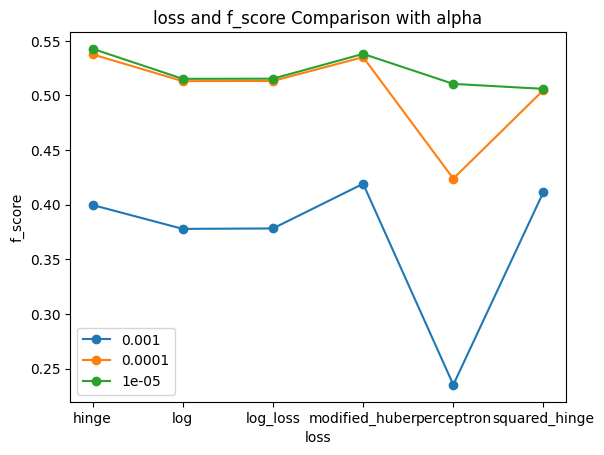

In [57]:
get_plot_scores("scores_issue_area1.csv","loss","f_score", np.mean, 'alpha')

In [ ]:
get_plot_scores("scores_issue_area1.csv","loss","f_score", np.mean, 'penalty')
get_plot_scores("scores_issue_area1.csv","loss","balanced_accuracy", np.mean, 'penalty')
get_plot_scores("scores_issue_area1.csv","loss","f_score_weighted", np.mean, 'penalty')
get_plot_scores("scores_issue_area1.csv","loss","kappa", np.mean, 'penalty')

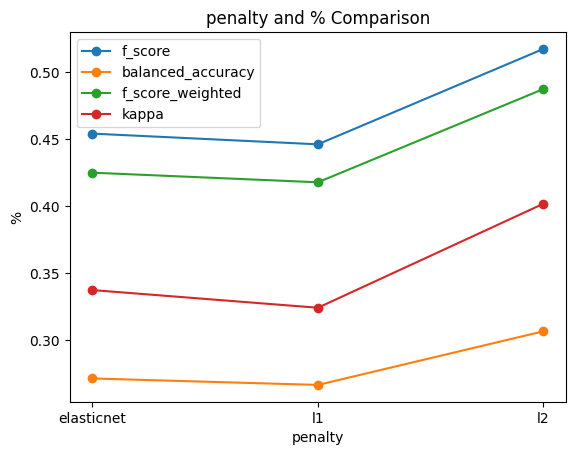

In [26]:
get_plot_scores("scores_issue_area1.csv","penalty","f_score", np.mean, ['f_score', 'balanced_accuracy', 'f_score_weighted', 'kappa'])

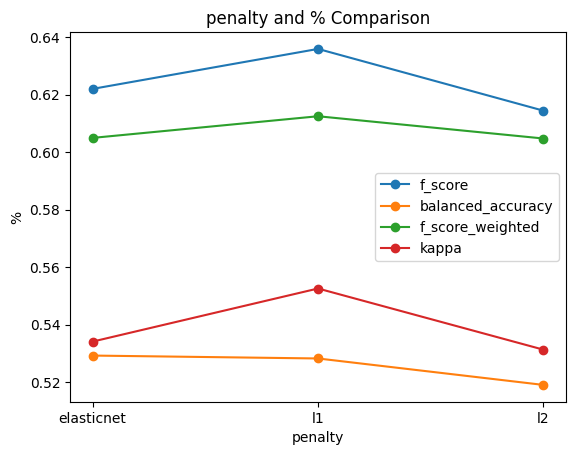

In [27]:
get_plot_scores("scores_issue_area1.csv","penalty","f_score", np.max, ['f_score', 'balanced_accuracy', 'f_score_weighted', 'kappa'])

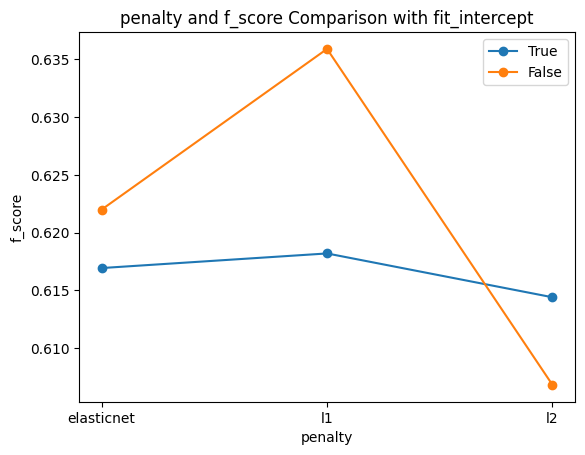

In [63]:
get_plot_scores("scores_issue_area1.csv","penalty","f_score", np.max, 'fit_intercept')

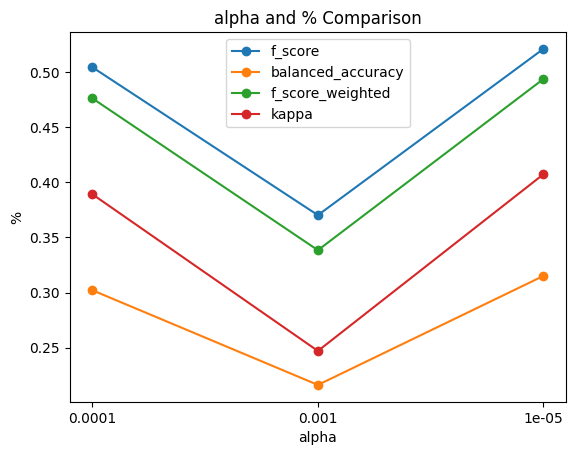

In [64]:
get_plot_scores("scores_issue_area1.csv","alpha", "f_score", np.mean, ['f_score', 'balanced_accuracy', 'f_score_weighted', 'kappa'])

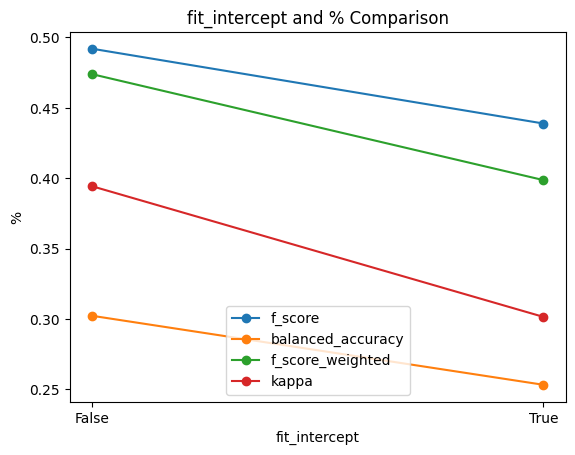

In [62]:
get_plot_scores("scores_issue_area1.csv","fit_intercept","f_score", np.mean, ['f_score', 'balanced_accuracy', 'f_score_weighted', 'kappa'])

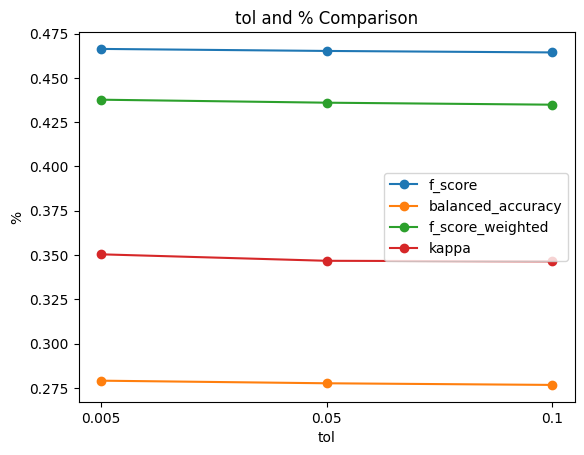

In [30]:
get_plot_scores("scores_issue_area1.csv","tol", "f_score", np.mean, ['f_score', 'balanced_accuracy', 'f_score_weighted', 'kappa'])

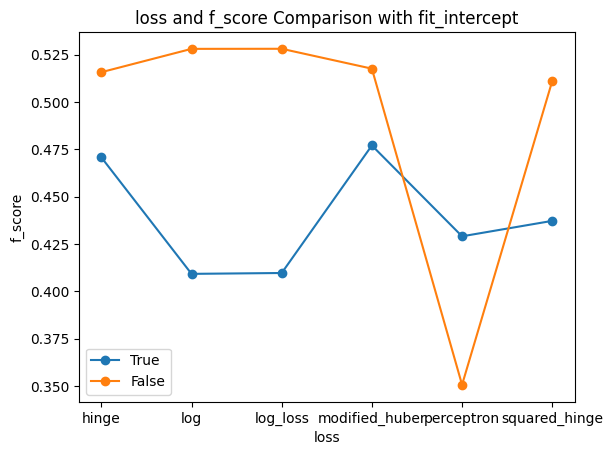

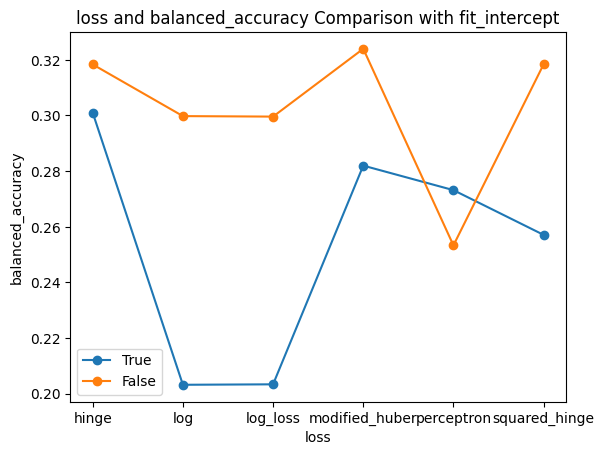

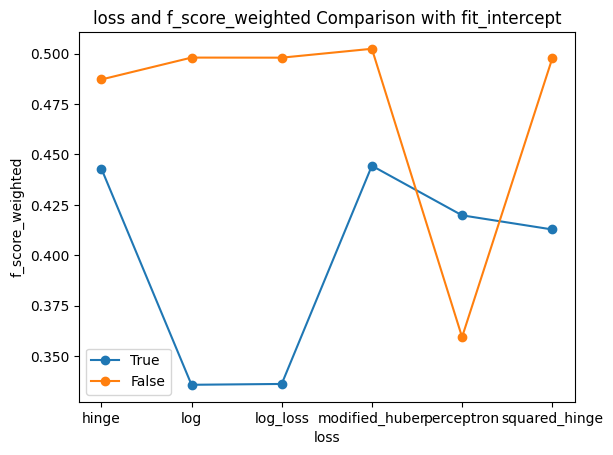

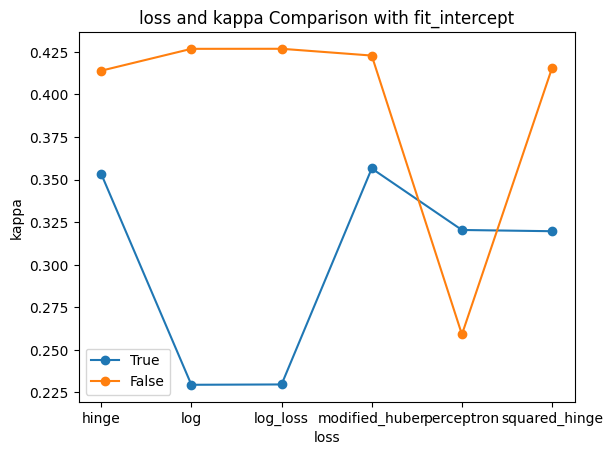

In [31]:
get_plot_scores("scores_issue_area1.csv","loss","f_score", np.mean, 'fit_intercept')
get_plot_scores("scores_issue_area1.csv","loss","balanced_accuracy", np.mean, 'fit_intercept')
get_plot_scores("scores_issue_area1.csv","loss","f_score_weighted", np.mean, 'fit_intercept')
get_plot_scores("scores_issue_area1.csv","loss","kappa", np.mean, 'fit_intercept')

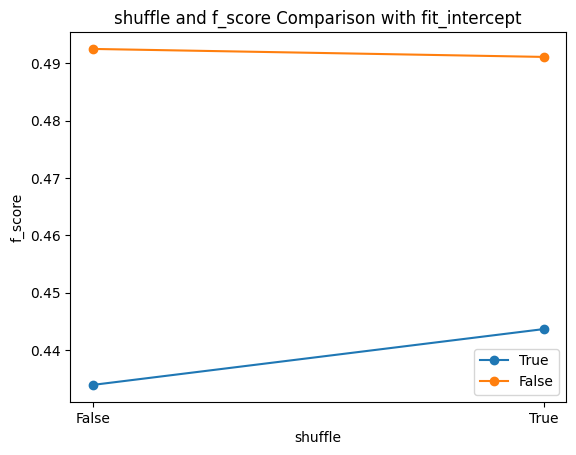

In [59]:
get_plot_scores("scores_issue_area1.csv", "shuffle", "f_score", np.mean, 'fit_intercept')

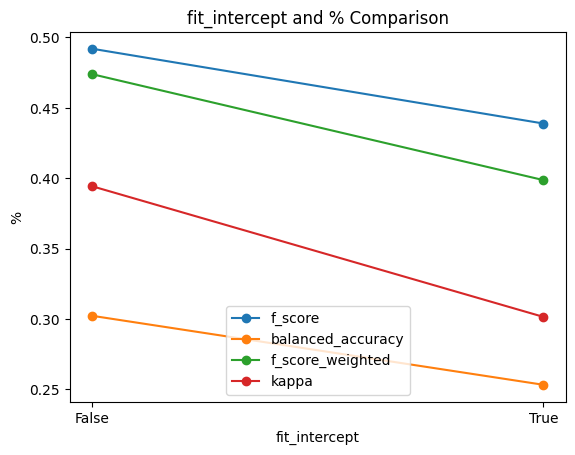

In [32]:
get_plot_scores("scores_issue_area1.csv","fit_intercept","f_score", np.mean, ['f_score', 'balanced_accuracy', 'f_score_weighted', 'kappa'])

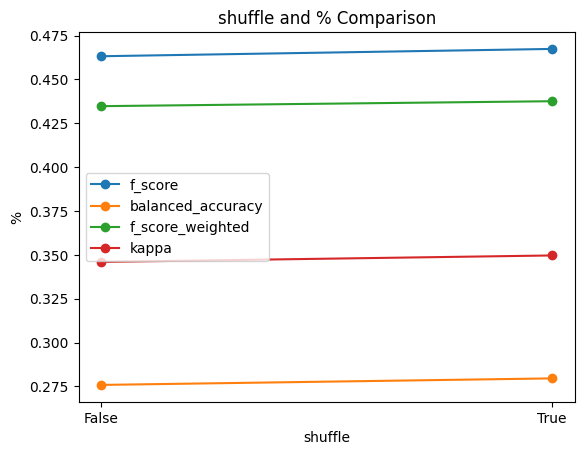

In [33]:
get_plot_scores("scores_issue_area1.csv","shuffle","f_score", np.mean, ['f_score', 'balanced_accuracy', 'f_score_weighted', 'kappa'])

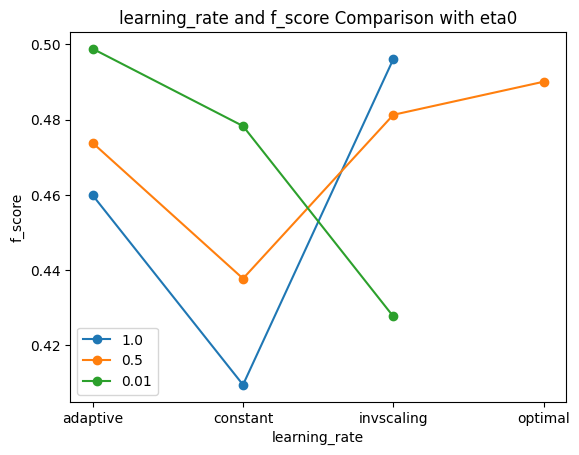

In [65]:
get_plot_scores("scores_issue_area1.csv","learning_rate","f_score", np.mean,'eta0')

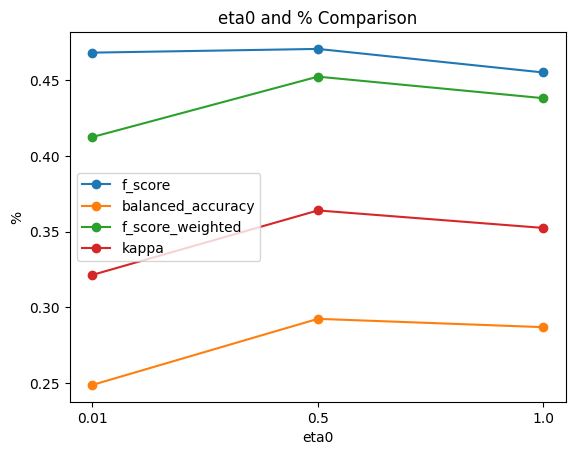

In [35]:
get_plot_scores("scores_issue_area1.csv","eta0","f_score", np.mean, ['f_score', 'balanced_accuracy', 'f_score_weighted', 'kappa'])

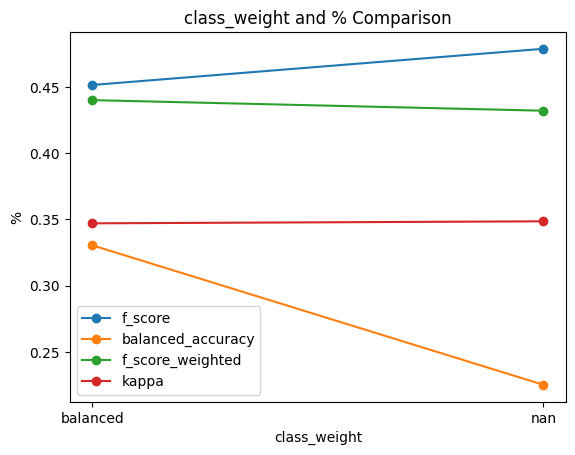

In [70]:
get_plot_scores("scores_issue_area1.csv","class_weight", "balanced_accuracy", np.mean, ['f_score', 'balanced_accuracy', 'f_score_weighted', 'kappa'])

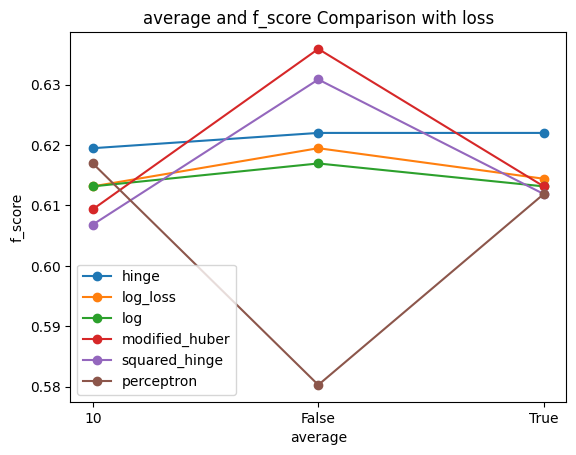

In [72]:
get_plot_scores("scores_issue_area1.csv","average","f_score", np.max, 'loss')

Best SGDC Classifier Models

In [38]:
#Better General Scores
def SGDC_model1_scores(X_train, Y_train, X_test, Y_test, max_iter, visualize=False):
    clf = SGDClassifier(loss='modified_huber',
                        penalty='l1',
                        alpha=0.001,
                        fit_intercept=False,
                        max_iter=max_iter,
                        tol=0.05,
                        shuffle=True,
                        learning_rate='adaptive',
                        eta0=1,
                        class_weight=None,
                        average=False).fit(X_train, Y_train)

    Y_pred = clf.predict(X_test)
    return get_scores(Y_test,Y_pred, visualize)

In [39]:
#Better Weighted Scores
def SGDC_model2_scores(X_train, Y_train, X_test, Y_test, max_iter, visualize=False):
    clf = SGDClassifier(loss='hinge',
                    penalty='elasticnet',
                    alpha=0.00001,
                    l1_ratio=0.5,
                    fit_intercept=False,
                    max_iter=max_iter,
                    tol=0.1,
                    shuffle=True,
                    learning_rate='constant',
                    eta0=1,
                    class_weight='balanced',
                    average=False).fit(X_train, Y_train)

    Y_pred = clf.predict(X_test)
    return get_scores(Y_test,Y_pred, visualize)

In [40]:
X_train, X_test, Y_train, Y_test = get_train_test(200, 0.2, X, Y)

f_score 0.6129541864139021
Balanced Accuracy 0.36136541408902356
Kappa Score 0.5211859435494328
Kappa Linear Score 0.4605182619195738
Kappa Quadratic Score 0.4230778052520886
                      precision    recall  f1-score   support

           Attorneys       0.00      0.00      0.00         4
        Civil Rights       0.46      0.58      0.51        85
  Criminal Procedure       0.79      0.91      0.84       188
         Due Process       0.75      0.11      0.19        28
   Economic Activity       0.50      0.74      0.59       112
    Federal Taxation       0.67      0.77      0.71        13
          Federalism       0.46      0.25      0.32        24
     First Amendment       0.71      0.61      0.65        76
Interstate Relations       0.00      0.00      0.00         1
      Judicial Power       0.37      0.18      0.24        72
       Miscellaneous       0.00      0.00      0.00         5
             Privacy       1.00      0.27      0.43        11
              Unio

(0.6129541864139021,
 0.36136541408902356,
 0.4897662323407688,
 0.36136541408902356,
 0.37692289083498304,
 0.6071749847483824,
 0.6129541864139021,
 0.5821433308414226,
 0.5211859435494328,
 0.4605182619195738,
 0.4230778052520886)

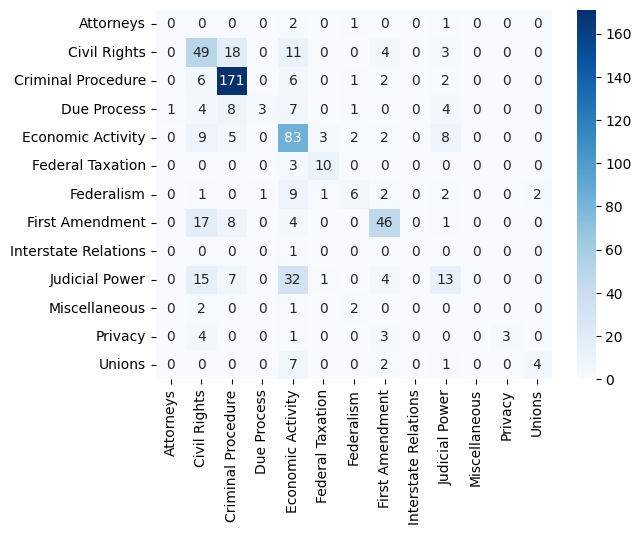

In [41]:
SGDC_model1_scores(X_train,Y_train,X_test,Y_test, 1000, True)

f_score 0.5039494470774092
Balanced Accuracy 0.4532588278124829
Kappa Score 0.42004721041313486
Kappa Linear Score 0.3894103367246049
Kappa Quadratic Score 0.3874190064794816
                      precision    recall  f1-score   support

           Attorneys       0.12      0.75      0.21         4
        Civil Rights       0.50      0.38      0.43        85
  Criminal Procedure       0.81      0.76      0.78       188
         Due Process       0.27      0.21      0.24        28
   Economic Activity       0.54      0.40      0.46       112
    Federal Taxation       0.55      0.92      0.69        13
          Federalism       0.21      0.42      0.28        24
     First Amendment       0.62      0.55      0.58        76
Interstate Relations       0.00      0.00      0.00         1
      Judicial Power       0.34      0.15      0.21        72
       Miscellaneous       0.05      0.20      0.08         5
             Privacy       0.36      0.36      0.36        11
      Private Acti

C:\Users\gorka\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


(0.5039494470774092,
 0.4532588278124829,
 0.33483950338503493,
 0.4208831972544484,
 0.3407542275116114,
 0.562894420517052,
 0.5039494470774092,
 0.519191918097734,
 0.42004721041313486,
 0.3894103367246049,
 0.3874190064794816)

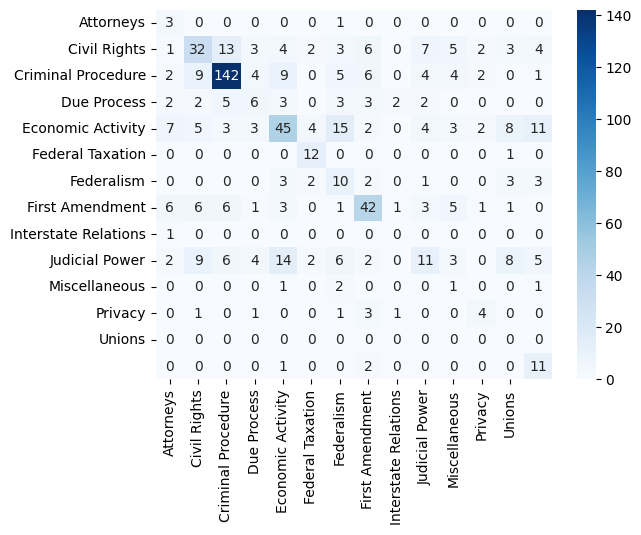

In [42]:
SGDC_model2_scores(X_train,Y_train,X_test,Y_test, 1000, True)

Best number of Topics and PCA search

In [43]:
def get_all_nTopics(X, Y, range_topics, range_PCA, max_iter):
    scores = []
    data_words = list(sent_to_words(X))
    data_words_nostops = remove_stopwords(data_words)
    data_lemmatized = lemmatization(data_words_nostops)
    for t in range_topics:
        model,corpus,topics = get_topicModeling(data_lemmatized, t)
        vectorized = get_vectorized(model,corpus)
        for p in [x for x in range_PCA if x <= t]:
            data_PCA,pca = get_PCA(vectorized,p)
            X_train, X_test, Y_train, Y_test = train_test(data_PCA, Y, 0.25)
            score = [t,p,max_iter]
            score += SGDC_model1_scores(X_train, Y_train, X_test, Y_test, max_iter)
            score += SGDC_model2_scores(X_train, Y_train, X_test, Y_test, max_iter)
            scores.append(score.copy())



    df_scores = pd.DataFrame(scores)
    df_scores = df_scores.set_axis(["nTopics", "PCA", 'max_iter', 'f_score1', 'balanced_accuracy1', 'precision_macro1', 'recall_macro1', 'f_score_macro1', 'precision_weighted1', 'recall_weighted1', 'f_score_weighted1', 'kappa1', 'kappa_linear1', 'kappa_quadratic1', 'f_score2', 'balanced_accuracy2', 'precision_macro2', 'recall_macro2', 'f_score_macro2', 'precision_weighted2', 'recall_weighted2', 'f_score_weighted2', 'kappa2', 'kappa_linear2', 'kappa_quadratic2'], axis="columns")
    df_scores.to_csv("scores_topics2.csv", encoding="utf-8", sep=',',index=False, header=True)
    return scores
range_topics = [20,50,150,300,500,1000,1250,1500,2000,3000]
#score_topics = get_all_nTopics(X,Y,range_topics, range_topics, 5000)

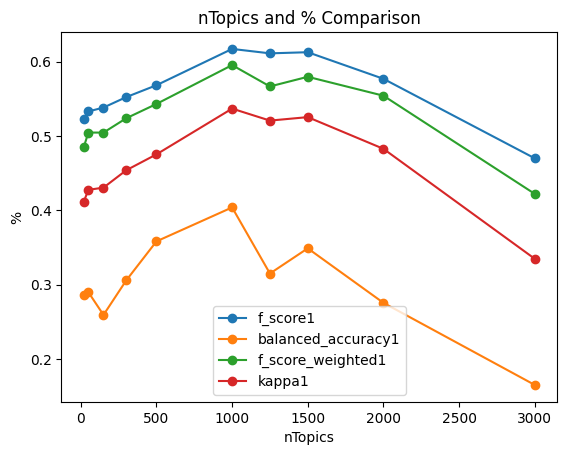

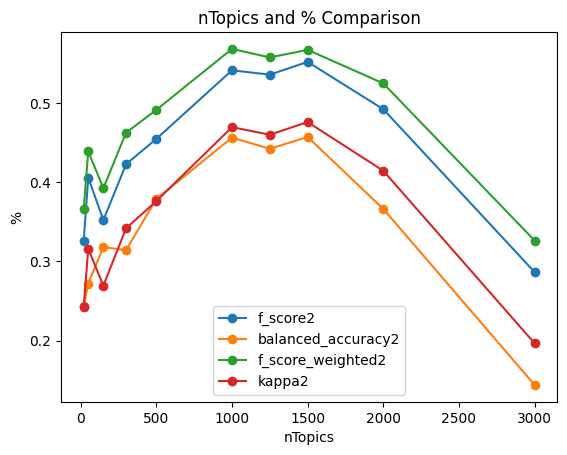

In [44]:
get_plot_scores("scores_topics1.csv","nTopics","f_score1", np.mean, ['f_score1', 'balanced_accuracy1', 'f_score_weighted1', 'kappa1'])
get_plot_scores("scores_topics1.csv", "nTopics","f_score1", np.mean, ['f_score2', 'balanced_accuracy2', 'f_score_weighted2', 'kappa2'])

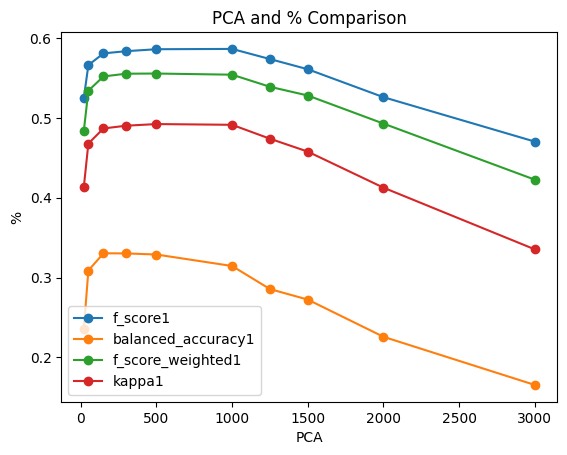

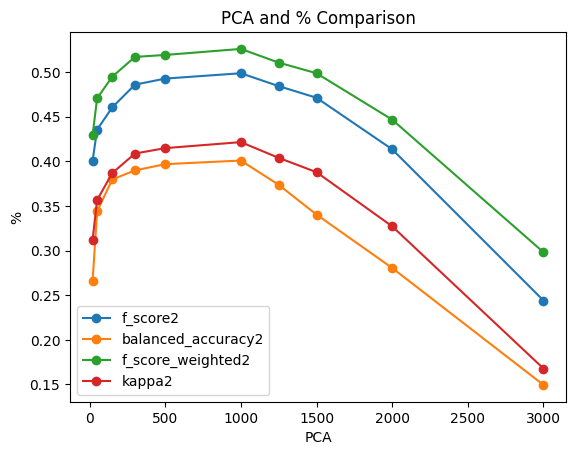

In [45]:
get_plot_scores("scores_topics1.csv","PCA","f_score1", np.mean, ['f_score1', 'balanced_accuracy1', 'f_score_weighted1', 'kappa1'])
get_plot_scores("scores_topics1.csv", "PCA","f_score2", np.mean, ['f_score2', 'balanced_accuracy2', 'f_score_weighted2', 'kappa2'])

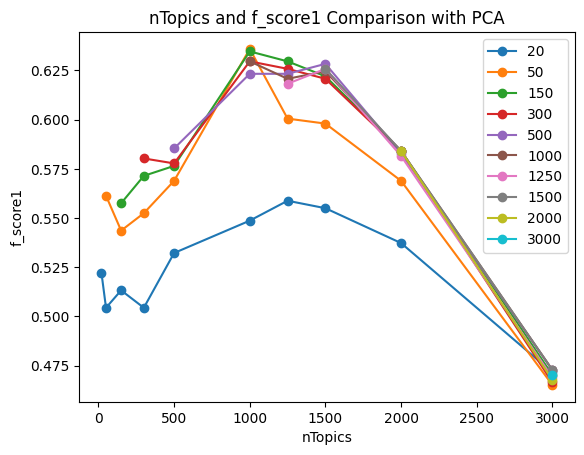

In [46]:
get_plot_scores("scores_topics1.csv","nTopics","f_score1", np.mean, 'PCA')

In [47]:
X_train, X_test, Y_train, Y_test = get_train_test(1000, 0.25, X, Y, 50)

Before: (3161, 1000)
After: (3161, 50)


f_score 0.6257901390644753
Balanced Accuracy 0.42667743498555194
Kappa Score 0.5466855631580374
Kappa Linear Score 0.5311061603935008
Kappa Quadratic Score 0.5384548903946855
                      precision    recall  f1-score   support

           Attorneys       0.20      0.40      0.27         5
        Civil Rights       0.64      0.68      0.66       111
  Criminal Procedure       0.88      0.80      0.84       237
         Due Process       0.12      0.06      0.08        32
   Economic Activity       0.50      0.78      0.61       137
    Federal Taxation       0.52      0.86      0.65        14
          Federalism       0.00      0.00      0.00        32
     First Amendment       0.65      0.67      0.66        93
Interstate Relations       0.00      0.00      0.00         1
      Judicial Power       0.36      0.22      0.27        91
       Miscellaneous       0.00      0.00      0.00         5
             Privacy       0.73      0.69      0.71        16
      Private Acti

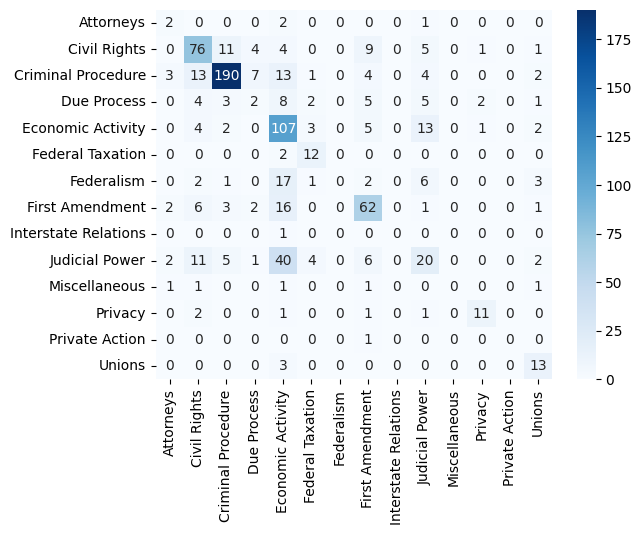

In [48]:
score = SGDC_model1_scores(X_train,Y_train, X_test, Y_test, 1000, True )

f_score 0.5474083438685209
Balanced Accuracy 0.4367244738464759
Kappa Score 0.4732424705210505
Kappa Linear Score 0.4763466525760861
Kappa Quadratic Score 0.4934985025256228
                      precision    recall  f1-score   support

           Attorneys       0.11      0.40      0.17         5
        Civil Rights       0.73      0.56      0.63       111
  Criminal Procedure       0.90      0.67      0.77       237
         Due Process       0.11      0.19      0.14        32
   Economic Activity       0.59      0.53      0.55       137
    Federal Taxation       0.37      1.00      0.54        14
          Federalism       0.12      0.06      0.08        32
     First Amendment       0.64      0.67      0.65        93
Interstate Relations       0.00      0.00      0.00         1
      Judicial Power       0.35      0.30      0.32        91
       Miscellaneous       0.00      0.00      0.00         5
             Privacy       0.40      0.75      0.52        16
      Private Actio

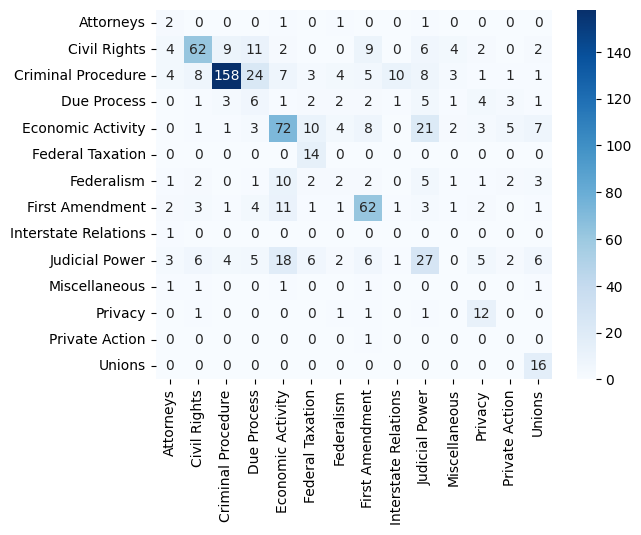

In [49]:
score = SGDC_model2_scores(X_train,Y_train, X_test, Y_test, 1000, True )

TF-IDF Scores

f_score 0.006321112515802781
Balanced Accuracy 0.07142857142857142
Kappa Score 0.0
Kappa Linear Score 0.0
Kappa Quadratic Score 0.0
                      precision    recall  f1-score   support

           Attorneys       0.01      1.00      0.01         5
        Civil Rights       0.00      0.00      0.00       111
  Criminal Procedure       0.00      0.00      0.00       237
         Due Process       0.00      0.00      0.00        32
   Economic Activity       0.00      0.00      0.00       137
    Federal Taxation       0.00      0.00      0.00        14
          Federalism       0.00      0.00      0.00        32
     First Amendment       0.00      0.00      0.00        93
Interstate Relations       0.00      0.00      0.00         1
      Judicial Power       0.00      0.00      0.00        91
       Miscellaneous       0.00      0.00      0.00         5
             Privacy       0.00      0.00      0.00        16
      Private Action       0.00      0.00      0.00         1

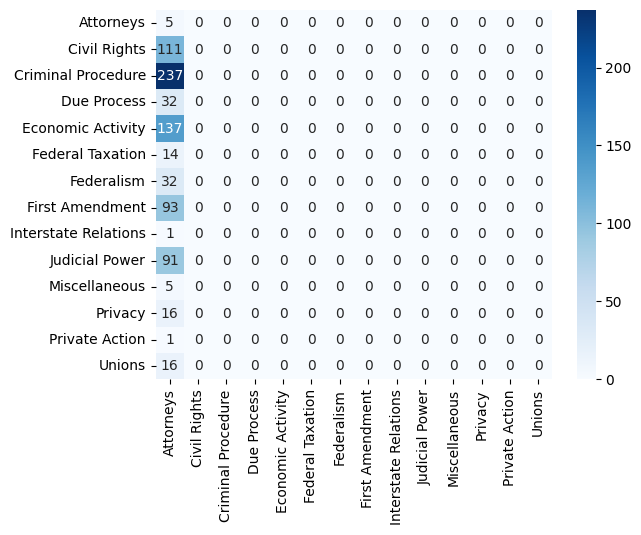

In [50]:
data_TF_IDF = get_tf_idf(X)
X_train, X_test, Y_train, Y_test = train_test(data_TF_IDF, Y, 0.25)
score1 = SGDC_model1_scores(X_train,Y_train, X_test, Y_test, 1000, True)


f_score 0.006321112515802781
Balanced Accuracy 0.07142857142857142
Kappa Score 0.0
Kappa Linear Score 0.0
Kappa Quadratic Score 0.0
                      precision    recall  f1-score   support

           Attorneys       0.01      1.00      0.01         5
        Civil Rights       0.00      0.00      0.00       111
  Criminal Procedure       0.00      0.00      0.00       237
         Due Process       0.00      0.00      0.00        32
   Economic Activity       0.00      0.00      0.00       137
    Federal Taxation       0.00      0.00      0.00        14
          Federalism       0.00      0.00      0.00        32
     First Amendment       0.00      0.00      0.00        93
Interstate Relations       0.00      0.00      0.00         1
      Judicial Power       0.00      0.00      0.00        91
       Miscellaneous       0.00      0.00      0.00         5
             Privacy       0.00      0.00      0.00        16
      Private Action       0.00      0.00      0.00         1

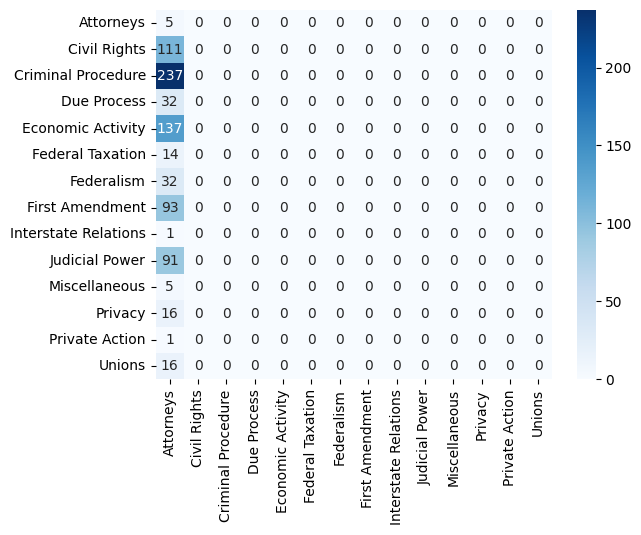

In [51]:
score1 = SGDC_model1_scores(X_train,Y_train, X_test, Y_test, 1000, True)

f_score 0.549936788874842
Balanced Accuracy 0.33356679291628694
Kappa Score 0.4233725811405754
Kappa Linear Score 0.352071609346147
Kappa Quadratic Score 0.346457605269195
                      precision    recall  f1-score   support

           Attorneys       0.33      0.20      0.25         5
        Civil Rights       0.50      0.57      0.53       111
  Criminal Procedure       0.59      0.97      0.73       237
         Due Process       0.00      0.00      0.00        32
   Economic Activity       0.50      0.77      0.60       137
    Federal Taxation       0.58      0.79      0.67        14
          Federalism       0.00      0.00      0.00        32
     First Amendment       1.00      0.03      0.06        93
Interstate Relations       0.00      0.00      0.00         1
      Judicial Power       0.50      0.01      0.02        91
       Miscellaneous       1.00      0.20      0.33         5
             Privacy       1.00      0.50      0.67        16
      Private Action 

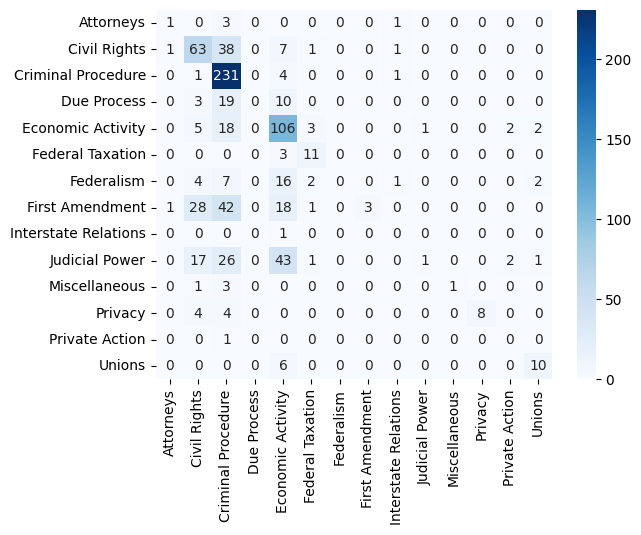

In [52]:
score2 = SGDC_model2_scores(X_train, Y_train, X_test, Y_test, 1000, True)

In [53]:
print(score1)
print(score2)

(0.006321112515802781, 0.07142857142857142, 0.0004515080368430558, 0.07142857142857142, 0.0008973438621679828, 3.995646343743856e-05, 0.006321112515802781, 7.94109612538038e-05, 0.0, 0.0, 0.0)
(0.549936788874842, 0.33356679291628694, 0.4759685846793218, 0.33356679291628694, 0.3225690508592594, 0.5599988923654292, 0.549936788874842, 0.45113039840600505, 0.4233725811405754, 0.352071609346147, 0.346457605269195)


Random Classifier

In [54]:
import random


def randomLabels(data, classes):
    labels = []
    for i in range(len(data)):
        rand_n = random.choice(classes)
        labels.append(rand_n)
    return labels

In [55]:
Y_pred = randomLabels(X, np.unique(Y))

f_score 0.07339449541284404
Balanced Accuracy 0.06495798352858263
Kappa Score 0.005014277995122662
Kappa Linear Score 0.0018359029495637058
Kappa Quadratic Score -0.001552557223369222
                      precision    recall  f1-score   support

           Attorneys       0.01      0.05      0.01        37
        Civil Rights       0.20      0.07      0.10       568
  Criminal Procedure       0.33      0.08      0.12       859
         Due Process       0.04      0.07      0.05       128
   Economic Activity       0.16      0.07      0.10       542
    Federal Taxation       0.02      0.08      0.03        51
          Federalism       0.03      0.06      0.04       125
     First Amendment       0.11      0.08      0.09       353
Interstate Relations       0.00      0.00      0.00         2
      Judicial Power       0.13      0.08      0.10       342
       Miscellaneous       0.01      0.15      0.02        20
             Privacy       0.02      0.06      0.03        70
      Pri

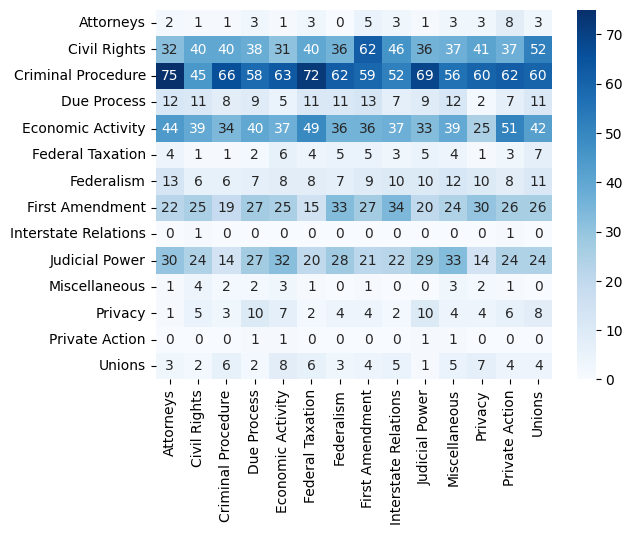

In [56]:
scores = get_scores(Y, Y_pred, True)